In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import pandas as pd
import pywt
import glob
from torch.utils.data import TensorDataset, DataLoader

In [2]:
device=torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
print(device)

cuda:0


In [3]:
M = 10020
data = []
labels = []

# 拿到数据路径，方便后续读取
dir_path = 'E:\\Desktop\\Python\\Length_width\\Data\\test'
# 获取目录及其子目录下所有CSV文件的路径
dataPaths = sorted(glob.glob(os.path.join(dir_path, '**', '*.csv'), recursive=True))
random.seed(42)
random.shuffle(dataPaths)

# 遍历读取数据
for dataPath in dataPaths:
    # 读取数据
    data_1 = pd.read_csv(dataPath)
    
    # 检查第一列的每一行，找到第一个大于0的值的位置N
    for N in range(len(data_1)):
        if data_1.iloc[N, 1] != 0:
            break
    
    # 如果找到了大于0的值，则从第二列的第N行开始，往后取10020个点
    if N < len(data_1):  # 确保N不会超出索引范围
        data.append(data_1.iloc[N:N+M, 1])
    
    # 从文件名中提取x, y, z标签
    filename = os.path.basename(dataPath)
    # 文件名格式为 "some_prefix_label1_label2.csv"
    parts = filename.split('_')
    # 提取最后一个"_"之前的部分作为prefix，之后的作为label1
    label1_str = parts[0]
    # 提取最后一个".csv"之前的部分作为label2
    label2_str = parts[1]
    
    # 将字符串标签转换为浮点数
    label1 = float(label1_str)
    label2 = float(label2_str)
    
    # 将两个标签值作为一个数组添加到labels列表中
    labels.append([label1, label2])

# 将数据和标签转换为numpy数组
test_data = np.array(data, dtype="float")
test_labels = np.array(labels)

In [4]:
test_datas = test_data.reshape(-1,test_data.shape[1],1)
print(test_datas.shape)

(310, 10020, 1)


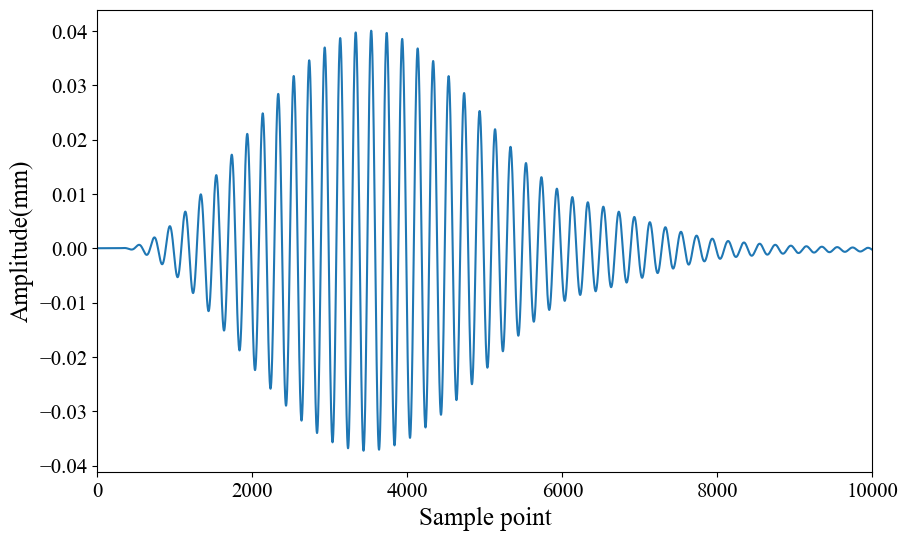

In [5]:
plt.style.use('default')
plt.figure(figsize=(10,6))
plt.rcParams['font.family'] = ['Times New Roman']
plt.plot(test_datas[5,:,:],linewidth=1.5)
plt.xlabel('Sample point',fontdict={'weight': 'normal', 'size': 18})
plt.ylabel('Amplitude(mm)',fontdict={'weight': 'normal', 'size': 18})
#坐标轴刻度大小设置
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlim([0,10000])
plt.savefig('E:\\Desktop\\Python\\Length_width\\Model\\NUT-DBLSTM_test\\test_data.jpg', dpi=600, bbox_inches='tight')

In [6]:
BATCH_SIZE = 1
input_size = 10058
hidden_size = 100
num_layers = 2
output_size = 2

In [7]:
test_dataset = TensorDataset(torch.from_numpy(test_datas),torch.from_numpy(test_labels))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_size*2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size//4)
        self.fc3 = nn.Linear(hidden_size//4, output_size)
        self.activate = nn.Tanh()

    def forward(self, x):
        wavelet = 'db4'
        # 将张量移动至CPU上面
        x1 = x.cpu()

        # 将CPU张量转化为numpy
        x2 = x1.numpy()
        #离散小波分解
        coeffs = pywt.wavedec(x2, wavelet, level=6)
        xh1=coeffs[0]
        xh2=coeffs[1]
        xh3=coeffs[2]
        xh4=coeffs[3]
        xh5=coeffs[4]
        xh6=coeffs[5]
        xl6=coeffs[6]
        # 连接分解后的序列
        x3 = np.concatenate((xh1,xh2,xh3,xh4,xh5,xh6,xl6),axis=-1)

        x4=torch.from_numpy(x3)
        x5=x4.to(device)

        h0 = torch.zeros(self.num_layers*2, x5.shape[0], self.hidden_size).to(x5.device)
        c0 = torch.zeros(self.num_layers*2, x5.shape[0], self.hidden_size).to(x5.device)

        out, _ = self.lstm(x5, (h0, c0))
        out1 = self.activate(out)
        out2 = self.fc1(out1[:, -1, :])
        out3 = self.fc2(out2)
        out4 = self.fc3(out3)
        return out4

In [9]:
model=torch.load('E:\\Desktop\\Python\\Length_width\\Model\\NUT-DBLSTM\\model_Length_width_LSTM.pth')  # 加载训练好的模型参数
model.to(device)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_8792\3149361127.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model=torch.load('E:\\Desktop\\Python\\Length_width\\

LSTMPredictor(
  (lstm): LSTM(10058, 100, num_layers=2, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=200, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=25, bias=True)
  (fc3): Linear(in_features=25, out_features=2, bias=True)
  (activate): Tanh()
)

In [10]:
# 将模型设置为评估模式
model.eval()  
# 进行预测

length_test=[]
width_test=[]

length_pred = []
width_pred = []
for i, (x, y) in enumerate(test_loader):

    x1=x.type(torch.FloatTensor)
    x2 = x1.permute(0,2,1) #将x1的维度进行调换，该例中将第1个维度保持不变，第2个维度和第3个进行交换
    x3,y=x2.to(device),y.to(device)
    
    length = y[:,0]
    width = y[:,1]

    length_test.append(length.item())
    width_test.append(width.item())

    with torch.no_grad():  # 关闭梯度计算
        outputs = model(x3)
        length_pred.append(outputs[:,0].item())
        width_pred.append(outputs[:,1].item())

In [11]:
length_pred1 = np.array(length_pred)

width_pred1 = np.array(width_pred)

from sklearn.metrics import r2_score
r2_length = r2_score(test_labels[:,0], length_pred1)
print(f'R² Score for length: {r2_length:.2f}')

r2_width = r2_score(test_labels[:,1], width_pred1)
print(f'R² Score for width: {r2_width:.2f}')

R² Score for length: 0.94
R² Score for width: -2.05


In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse_length = mean_squared_error(test_labels[:,0], length_pred)
print(f'MSE_length: {mse_length:.3f}:')

mse_width = mean_squared_error(test_labels[:,1], width_pred)
print(f'MSE_width: {mse_width:.3f}:')

# 计算 MAE
mae_length = mean_absolute_error(test_labels[:,0], length_pred)
print(f'MAE_length: {mae_length:.3f}')

mae_width = mean_absolute_error(test_labels[:,1], width_pred)
print(f'MAE_width: {mae_width:.3f}')

MSE_length: 3.033:
MSE_width: 0.082:
MAE_length: 0.257
MAE_width: 0.054


In [13]:
def mape(y_true, y_pred):
    n = len(y_true)
    if n == 0:
        return 0
    errors = np.abs((y_true - y_pred) / y_true)
    return np.mean(errors) * 100

# test_labels是二维的numpy数组，[:, 0]表示取第一列作为长度相关的真实值
# length_pred是对应的长度预测值
mape_length = mape(test_labels[:, 0], length_pred)
print(f'MAPE_length: {mape_length:.3f}')

mape_width = mape(test_labels[:, 0], width_pred)
print(f'MAPE_width: {mape_width:.3f}')

MAPE_length: 3.680
MAPE_width: 92.359


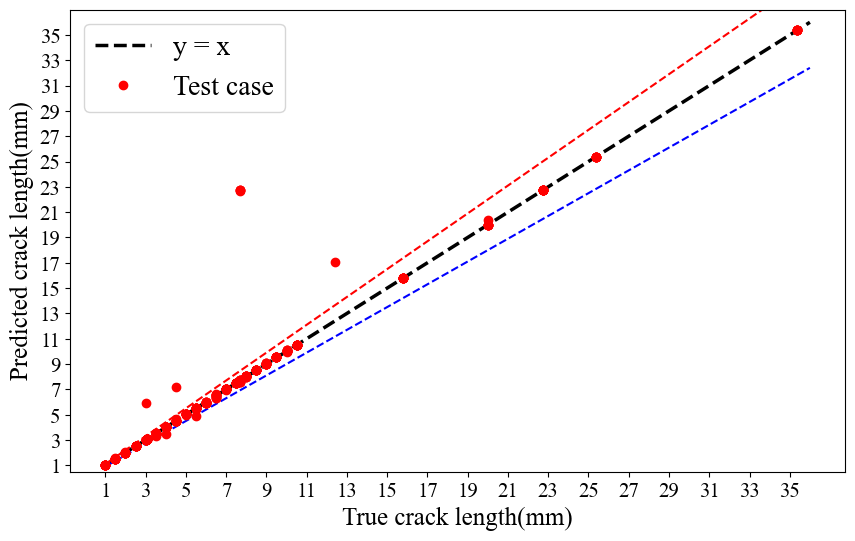

In [14]:
# 绘图命令
plt.style.use('default')
plt.figure(figsize=(10, 6)) #创建Figure对象，并指定尺寸
plt.rcParams['font.family'] = ['Times New Roman']
length_true=np.arange(np.min(test_labels[:,0]),np.max(test_labels[:,0])+1,0.5)
plt.plot(length_true,length_true,'k--', label='y = x',linewidth=2.5)

plt.plot(length_true, 1.1*length_true,'r--',linewidth=1.5)
plt.plot(length_true, 0.9*length_true,'b--',linewidth=1.5)

# 绘制红色实心圆
plt.plot(test_labels[:,0],length_pred1, marker='o', markersize=6, color='red', linestyle='None',label='Test case')

#plt.text(8, 2, f'R\u00B2={r2:.2f}', fontsize=20, color='black')  # 在坐标 (2, 0) 位置插入文本

plt.xlabel('True crack length(mm)',fontdict={'weight': 'normal', 'size': 18})
plt.ylabel('Predicted crack length(mm)',fontdict={'weight': 'normal', 'size': 18})

# 设置坐标轴刻度
plt.xticks(np.arange(length_true.min(),length_true.max()+1,2))  
plt.yticks(np.arange(length_true.min(),length_true.max()+1,2)) 

plt.ylim([0.5, length_true.max()+1]) 

#坐标轴刻度大小设置
plt.tick_params(axis='both', which='major', labelsize=15) 

plt.legend(fontsize=20)

plt.savefig('E:\\Desktop\\Python\\Length_width\\Model\\NUT-DBLSTM_test\\Length_Prediction_LSTM.jpg', dpi=600, bbox_inches='tight')

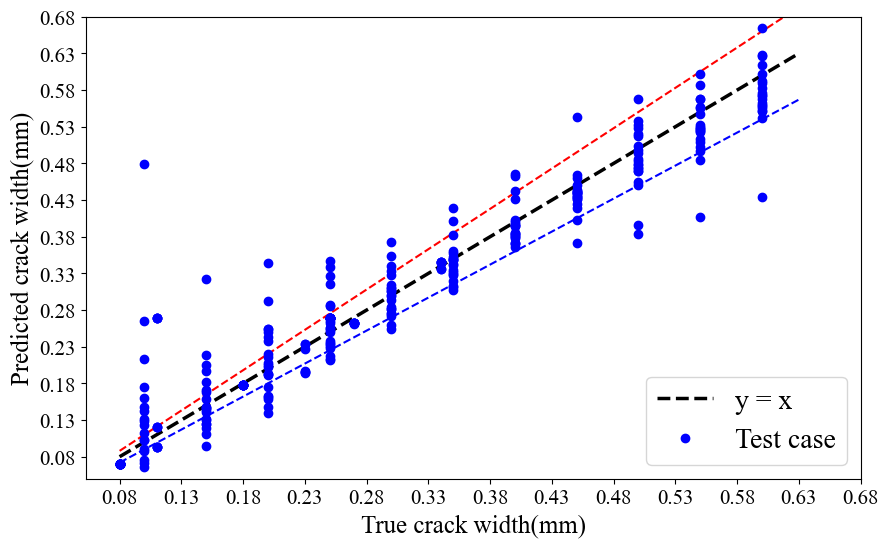

In [15]:
# 绘图命令
plt.style.use('default')
plt.figure(figsize=(10, 6)) #创建Figure对象，并指定尺寸
plt.rcParams['font.family'] = ['Times New Roman']
width_true=np.arange(np.min(test_labels[:,1]),np.max(test_labels[:,1])+0.05,0.05)
plt.plot(width_true,width_true,'k--', label='y = x',linewidth=2.5)

plt.plot(width_true, 1.1*width_true,'r--',linewidth=1.5)
plt.plot(width_true, 0.9*width_true,'b--',linewidth=1.5)

# 绘制红色实心圆
plt.plot(test_labels[:,1],width_pred1, marker='o', markersize=6, color='blue', linestyle='None',label='Test case')

#plt.text(8, 2, f'R\u00B2={r2:.2f}', fontsize=20, color='black')  # 在坐标 (2, 0) 位置插入文本

plt.xlabel('True crack width(mm)',fontdict={'weight': 'normal', 'size': 18})
plt.ylabel('Predicted crack width(mm)',fontdict={'weight': 'normal', 'size': 18})

# 设置坐标轴刻度
plt.xticks(np.arange(width_true.min(),width_true.max()+0.05,0.05))  
plt.yticks(np.arange(width_true.min(),width_true.max()+0.05,0.05))

plt.ylim([0.05, width_true.max()+0.05]) 

#坐标轴刻度大小设置
plt.tick_params(axis='both', which='major', labelsize=15) 

plt.legend(fontsize=20,loc='lower right')

plt.savefig('E:\\Desktop\\Python\\Length_width\\Model\\NUT-DBLSTM_test\\Width_Prediction_LSTM.jpg', dpi=600, bbox_inches='tight')